In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaisermikael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/kaisermikael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Data Exploration**

Need to change encoder to latin-1 due to CSV encoding differences from UTF-8 default.

In [2]:
chatbot = pd.read_csv('Sheet_1.csv', encoding='latin-1')
chatbot.head()

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN


In [3]:
resume = pd.read_csv('Sheet_2.csv', encoding='latin-1')
resume.head()

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...


Resume reading looks fine, but for the chatbot we need to remove the empty columns

In [4]:
chatbot = chatbot[['response_id','class','response_text']]
chatbot.head()

,response_id,class,response_text
0,response_1,not_flagged,I try and avoid this sort of conflict
1,response_2,flagged,Had a friend open up to me about his mental ad...
2,response_3,flagged,I saved a girl from suicide once. She was goin...
3,response_4,not_flagged,i cant think of one really...i think i may hav...
4,response_5,not_flagged,Only really one friend who doesn't fit into th...


Now, both dataframes are the same column types and we can proceed with cleaning up our datavalues. First we remove all NaN values and then identify any data imbalance.

Chatbot Class Counts: 0    55
1    25
Name: class, dtype: int64


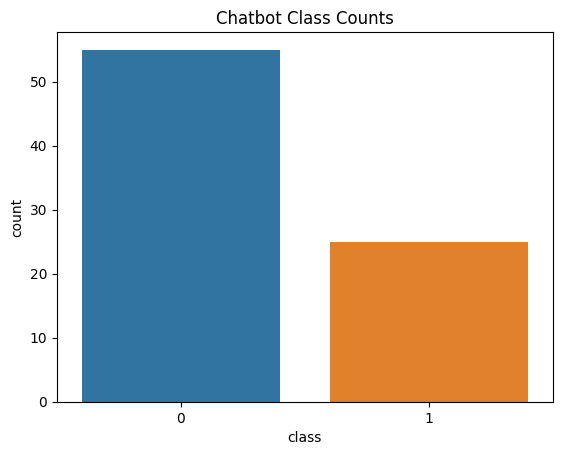

In [16]:
chatbot.dropna(inplace=True)
class_histo = sns.countplot(chatbot, x='class').set_title('Chatbot Class Counts')
print("Chatbot Class Counts:",chatbot['class'].value_counts())

Resume Class Counts: 0    92
1    33
Name: class, dtype: int64


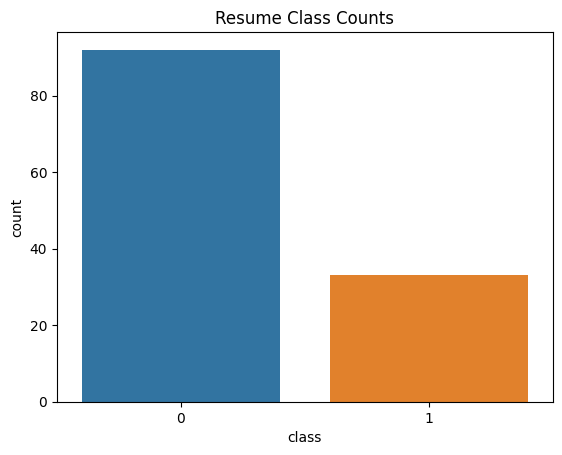

In [17]:
resume.dropna(inplace=True)
resume_histo = sns.countplot(resume, x='class').set_title('Resume Class Counts')
print("Resume Class Counts:",resume['class'].value_counts())

**Tokenization and Cleaning**

Now, we tokenize and then clean up our text to improve the NLP results.

In [7]:
# Lowercase all text
chatbot['response_text'] = chatbot['response_text'].astype(str).str.lower()
resume['resume_text'] = resume['resume_text'].astype(str).str.lower()

# Tokenize the text
from nltk.tokenize import word_tokenize, RegexpTokenizer

regexp = RegexpTokenizer('\w+')

chatbot['text_token'] = chatbot['response_text'].apply(regexp.tokenize)
resume['text_token'] = resume['resume_text'].apply(regexp.tokenize)

print("Chatbot Tokenized Text:")
print(chatbot.head())
print()
print("Resume Tokenized Text:")
print(resume.head())

Chatbot Tokenized Text:
  response_id        class                                      response_text  \
0  response_1  not_flagged              i try and avoid this sort of conflict   
1  response_2      flagged  had a friend open up to me about his mental ad...   
2  response_3      flagged  i saved a girl from suicide once. she was goin...   
3  response_4  not_flagged  i cant think of one really...i think i may hav...   
4  response_5  not_flagged  only really one friend who doesn't fit into th...   

                                          text_token  
0     [i, try, and, avoid, this, sort, of, conflict]  
1  [had, a, friend, open, up, to, me, about, his,...  
2  [i, saved, a, girl, from, suicide, once, she, ...  
3  [i, cant, think, of, one, really, i, think, i,...  
4  [only, really, one, friend, who, doesn, t, fit...  

Resume Tokenized Text:
  resume_id        class                                        resume_text  \
0  resume_1  not_flagged  \rcustomer service supervisor/

Now, punctuation has been removed and we can now remove misspelled words (words due the tokenization or from user misspelling). We can also now remove very uncommon words that won't be applicable (like names) as well as the stopwords that are not indicative of sentiment.

In [8]:
from nltk.corpus import stopwords

stopwords = nltk.corpus.stopwords.words('english')

# Add custom stopwords after performing more data exploration
custom_stopwords = ['']
stopwords.extend(custom_stopwords)

In [9]:
chatbot['text_token'] = chatbot['text_token'].apply(lambda x: [word for word in x if word not in stopwords])
resume['text_token'] = resume['text_token'].apply(lambda x: [word for word in x if word not in stopwords])

In [10]:
chatbot['response_text'] = chatbot['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
resume['resume_text'] = resume['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

chatbot_tokens = ' '.join([token for token in chatbot['response_text']])
resume_tokens = ' '.join([token for token in resume['resume_text']])

chatbot_tokenized_words = word_tokenize(chatbot_tokens)
resume_tokenized_words = word_tokenize(resume_tokens)

Now that both datasets are tokenized and have all stopwords removed, we can consider using the NLTK FreqDist to remove words that only appear once.

In [11]:
from nltk.probability import FreqDist

chatbot_freq = FreqDist(chatbot_tokenized_words)
resume_freq = FreqDist(resume_tokenized_words)

In [12]:
chatbot['text_string_fdist'] = chatbot['text_token'].apply(lambda x: ' '.join([item for item in x if chatbot_freq[item] > 1]))
resume['text_string_fdist'] = resume['text_token'].apply(lambda x: ' '.join([item for item in x if resume_freq[item] > 1]))

print(chatbot.head())
print()
print(resume.head())

  response_id        class                                      response_text  \
0  response_1  not_flagged                            try avoid sort conflict   
1  response_2      flagged  friend open mental addiction weed taking life ...   
2  response_3      flagged  saved girl suicide going swallow bunch pills t...   
3  response_4  not_flagged         cant think one really think may indirectly   
4  response_5  not_flagged  really one friend fit categories therapist cal...   

                                          text_token  \
0                       [try, avoid, sort, conflict]   
1  [friend, open, mental, addiction, weed, taking...   
2  [saved, girl, suicide, going, swallow, bunch, ...   
3  [cant, think, one, really, think, may, indirec...   
4  [really, one, friend, fit, categories, therapi...   

                                   text_string_fdist  
0                                                try  
1  friend open mental addiction life making depre...  
2          

Because this dataset is not exceptionally large, we can see that using this FreqDist method actually ends up removing a lot of words that would be useful for our analysis (for example, in the very first response, we would lose words like "avoid" and "conflict", which may or may not be useful). As such, we're going to not use this method. But it could be useful in a larger dataset in the future, so is worth noting.

In [13]:
# If we ever were to use the text_string_fdist column, we would comment these lines out.
chatbot.drop(columns=['text_string_fdist'], inplace=True)
resume.drop(columns=['text_string_fdist'], inplace=True)

Finally, we replace "not_flagged" and "flagged" with 0 and 1 to make NLP easier.

In [14]:
chatbot['class'].replace('flagged','1',inplace=True)
chatbot['class'].replace('not_flagged','0',inplace=True)

resume['class'].replace('flagged','1',inplace=True)
resume['class'].replace('not_flagged','0',inplace=True)

With this, we conclude our preprocessing and are now ready for the actual deep learning analysis. We finish by exporting our results to new CSV files for future use so we don't have to always run this again.

In [15]:
chatbot.to_csv('chatbot_cleaned.csv', index=False)
resume.to_csv('resume_cleaned.csv', index=False)